In [19]:
using MPSExperiments
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, Graphs
using Plots, Statistics

random_bipartite_regular (generic function with 1 method)

In [2]:
nA = 10^3
nB = nA
kA = 3
kB = kA

# asymmetric interactions
JA = 0.3
JB = 0.7
h = 0.2;

In [4]:
n = nA + nB
include("random_bipartite_regular.jl")
A = random_bipartite_regular(nA, nB, kA, kB)
gg = BipartiteIndexedGraph(A)
g = IndexedBiDiGraph(adjacency_matrix(gg));

## Montecarlo


In [5]:
T = 100
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ nA ? JA : JB, h), T+1)
end
m⁰ = 0.0
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], n)

bp = mpbp(g, w, fill(2, n), T; ϕ)
sms = SoftMarginSampler(bp);

In [6]:
sample!(sms, 5*10^2);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:06


In [7]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m_mc = [[mss.val for mss in ms] for ms in means(spin, sms)];


Marginals from Soft Margin  80%|███████████████████▉     |  ETA: 0:00:00

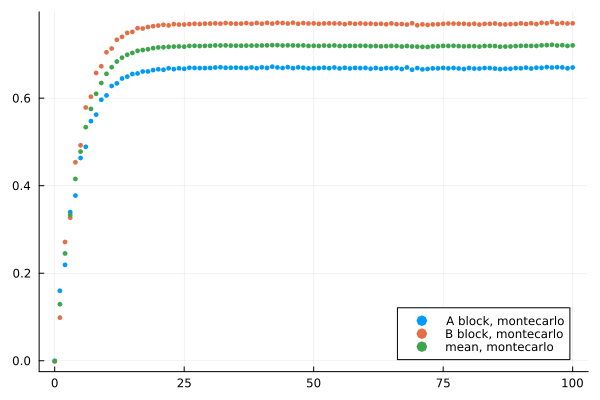

In [47]:
pl_mc = plot()
scatter!(0:T, mean(m_mc[1:nA]), label="A block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc[nA+1:end]), label="B block, montecarlo"; m=:o, ms=2.5, msc=:auto)
scatter!(0:T, mean(m_mc), label="mean, montecarlo"; m=:o, ms=2.5, msc=:auto)

## MPBP

In [24]:
g = IndexedBiDiGraph(complete_bipartite_graph(kA, kB))
w = map(vertices(g)) do i
    fill(HomogeneousGlauberFactor(i ≤ kA ? JA : JB, h), T+1)
end
ϕ = fill([ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T], kA+kB)
bp = mpbp(g, w, fill(2, kA+kB), T; ϕ);

In [41]:
cb = CB_BP(bp)
iterate!(bp; maxiter=20, svd_trunc=TruncBond(10),
    cb, tol=1e-5);

Running MPBP: iter 2    Time: 0:00:57

Running MPBP: iter 3    Time: 0:01:40

Running MPBP: iter 4    Time: 0:02:00

Running MPBP: iter 5    Time: 0:02:12

Running MPBP: iter 6    Time: 0:02:23

Running MPBP: iter 7    Time: 0:02:36

Running MPBP: iter 8    Time: 0:02:50

Running MPBP: iter 9    Time: 0:03:04

Running MPBP: iter 10    Time: 0:03:17

Running MPBP: iter 11    Time: 0:03:29

Running MPBP: iter 12    Time: 0:03:42

Running MPBP: iter 13    Time: 0:03:54

Running MPBP: iter 14    Time: 0:04:06

Running MPBP: iter 15    Time: 0:04:18

Running MPBP: iter 16    Time: 0:04:31

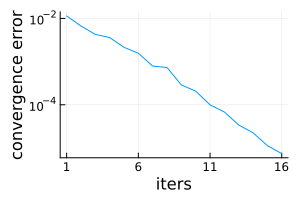

In [42]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [43]:
m_bp[kA+1:end]

3-element Vector{Vector{Float64}}:
 [0.016696733668373154, 0.1193771418287351, 0.314254898352925, 0.3623214613100254, 0.5110141805325881, 0.5364643380324114, 0.6424297830986485, 0.652854324530193, 0.7159629416245752, 0.7185256118427066  …  0.7887817187623969, 0.7883060729022096, 0.787969683180614, 0.7871604144679218, 0.7865401268594193, 0.7853685762805954, 0.7839886387317796, 0.7826793963609393, 0.7804981026149398, 0.7794311106953764]
 [0.016696733668373154, 0.1193771418287351, 0.314254898352925, 0.3623214613100254, 0.5110141805325881, 0.5364643380324114, 0.6424297830986485, 0.652854324530193, 0.7159629416245752, 0.7185256118427066  …  0.7887817187623969, 0.7883060729022096, 0.787969683180614, 0.7871604144679218, 0.7865401268594193, 0.7853685762805954, 0.7839886387317796, 0.7826793963609393, 0.7804981026149398, 0.7794311106953764]
 [0.01669673366837071, 0.11937714182873427, 0.3142548983529219, 0.3623214613100215, 0.5110141805325863, 0.5364643380324068, 0.6424297830986467, 0.65285432453

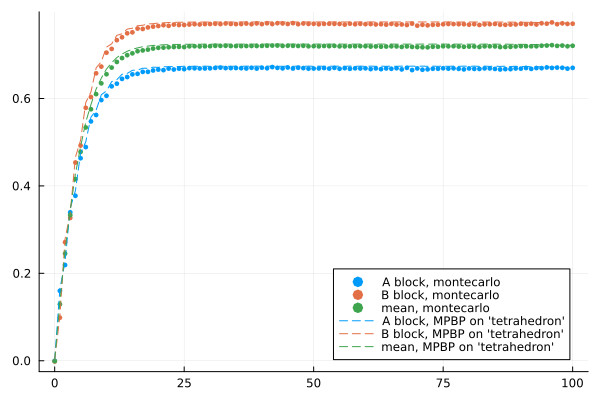

In [53]:
m_bp = means(spin, bp)

pl_bp = deepcopy(pl_mc)
plot!(pl_bp, 0:T, mean(m_bp[1:kA]), c=theme_palette(:auto)[1],
    label="A block, MPBP on 'tetrahedron'", ls=:dash)
plot!(pl_bp, 0:T, mean(m_bp[kA+1:end]), c=theme_palette(:auto)[2],
    label="B block, MPBP on 'tetrahedron'", ls=:dash)
plot!(pl_bp, 0:T, mean(m_bp), c=theme_palette(:auto)[3], 
    label="mean, MPBP on 'tetrahedron'", ls=:dash)

## BP + VUMPS

In [49]:
fA = HomogeneousGlauberFactor(JA, h)
fB = HomogeneousGlauberFactor(JB, h);

In [57]:
d = 10

A0 = reshape([0.45 0.45; 0.1 0.1], 1, 1, 2, 2)
B0 = copy(A0)

A, B, maxiter, εs, errs, ovls, beliefs, beliefsA, beliefsB, As, Bs = iterate_bp_vumps_bipartite(
    fA, fB, d; A0, B0
)

┌ Info: VOMPS init:	err = 1.3119e-01
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 1.9767714022e-01	time = 0.00 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   2:	err = 1.4901362455e-03	time = 0.01 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   3:	err = 1.0065968373e-07	time = 0.01 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS conv 4:	err = 7.4306278983e-16	time = 0.02 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:51
┌ Info: VOMPS init:	err = 9.6731e-02
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:26
┌ Info: VOMPS   1:	err = 1.3631768527e-01	time = 0.02 sec
└ @ MPSKit /home/crotti/.julia/dev/MPSKit/src/algorithms/approximate/vomps.jl:57
┌ Info: VOMPS   2:	err = 1.2995705970e-02	time = 0.02 sec
└ @ MPSK

([1.0 0.42637432359121424 … -0.04083576559165638 0.2796248541797035; 0.012612173502060037 -0.42659221208302683 … -0.36499391908146556 0.01791943446276501; … ; 0.015920778335187822 0.4260065492733028 … 0.09069436849961286 -0.10721559993589887; 0.017295588525122488 -0.28457965692941845 … 0.43442623740599573 0.2718092753941741;;; 0.20096342362636782 0.020487458639016548 … 0.5877525876424212 0.11301061325229905; 0.028421455076688962 -0.20261780254915784 … -0.08629017980208441 -0.3941705219449357; … ; -0.07008761662536996 0.11266540390930883 … -0.09731490180268808 0.23450314407211442; -0.03853044779898854 0.10425488097515682 … -0.0960057891894408 0.19319230374808122;;;; 0.8394983196433063 -0.38104762804746395 … -0.13378411227989098 -0.10604182154749037; 0.003955063038813584 -0.08988801558379947 … -0.10221290244101491 -0.07649582399833321; … ; -0.0006097167756732769 0.13606652090736937 … -0.02465241056987159 0.004716095498858456; 0.05555155064107488 -0.24378459881120468 … 0.25613636537975454

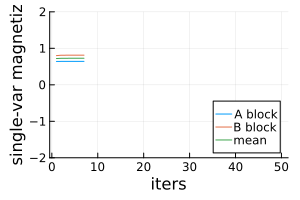

In [58]:
mA = [reduce(-, b) for b in beliefsA]
mB = [reduce(-, b) for b in beliefsB]
m = [reduce(-, b) for b in beliefs]

pl = plot()
plot!(mA, ylabel="single-var magnetiz", label="A block")
plot!(mB, ylabel="single-var magnetiz", label="B block")
plot!(m, ylabel="single-var magnetiz", label="mean")
plot!(ylims=(-2,2), legend=:bottomright, xlabel="iters", size=(300,200))

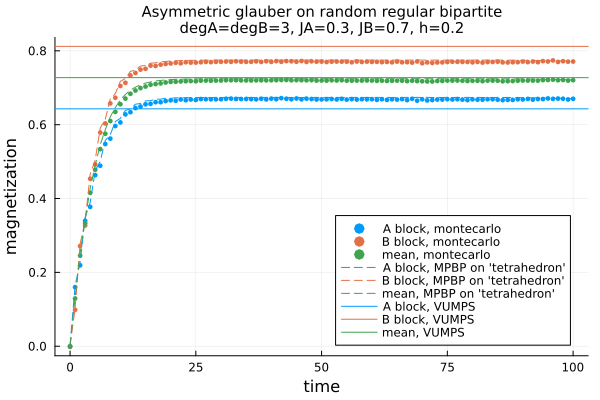

In [59]:
mAstat = mA[findlast(!isnan, mA)]
mBstat = mB[findlast(!isnan, mB)]
mstat = m[findlast(!isnan, m)]

pl2 = deepcopy(pl_bp)
plot!(pl2, title="Asymmetric glauber on random regular bipartite\ndegA=degB=3, JA=$JA, JB=$JB, h=$h",
    titlefontsize=10, xlabel="time", ylabel="magnetization")
hline!(pl2, [mAstat], c=theme_palette(:auto)[1], label="A block, VUMPS")
hline!(pl2, [mBstat], c=theme_palette(:auto)[2], label="B block, VUMPS")
hline!(pl2, [mstat], c=theme_palette(:auto)[3], label="mean, VUMPS")